### <center>Demand estimation for food distribution in schools-Part1</center>
<center>Operations Analytics - Prof Debjit Roy: Group Assignment 6</center>
<center>ePGD ABA 2020-21</center>
<center>Review made by Kanika Gupta (aba20kanikag@iima.ac.in) & Abhilash Agnihotri (aba20akshays@iima.ac.in)</center>

In [1]:
# !pip install --quiet feature_engine
# !pip install --quiet feature_engine --upgrade --no-deps
# !pip install --quiet sklearn
# !pip install --quiet sklearn --upgrade --no-deps
# !pip install --quiet kmodes
# !pip install --quiet pyclustering
# !pip install --quiet gower

In [2]:
#Import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import math
import statsmodels.api as sm

In [3]:
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from feature_engine.discretisers import EqualFrequencyDiscretiser
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

In [4]:
# !pip install --quiet gower
import gower

In [5]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score
from scipy.spatial.distance import pdist

In [6]:
# !pip install --quiet kmodes
from kmodes.kmodes import KModes

In [7]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [8]:
# !pip install --quiet pyclustering

In [9]:
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.silhouette import silhouette
from pyclustering.cluster.encoder import type_encoding, cluster_encoder
from pyclustering.utils.metric import type_metric, distance_metric

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
#Import data
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/articles/school_enrollment_list.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0, index_col=None)

In [12]:
dataset.head()

,Center_No,Sl.No.,Tot_enrol,S_1_5_Boys,S_1_5_Girls,S_6_8_Boys,S_6_8_Girls,Loc_type
0,GXZ-CU1,1,42,14,16,4,8,City
1,GXZ-CU2,2,206,48,33,81,44,City
2,GXZ-CU3,3,93,25,26,14,28,City
3,GXZ-CU4,4,126,36,42,27,21,City
4,GXZ-CU5,5,65,27,17,13,8,City


In [13]:
# Checking Null values
dataset.isnull().sum()*100/dataset.shape[0]

Center_No      0.0
Sl.No.         0.0
Tot_enrol      0.0
S_1_5_Boys     0.0
S_1_5_Girls    0.0
S_6_8_Boys     0.0
S_6_8_Girls    0.0
Loc_type       0.0
dtype: float64

In [14]:
dataset.describe()

,Sl.No.,Tot_enrol,S_1_5_Boys,S_1_5_Girls,S_6_8_Boys,S_6_8_Girls
count,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,64.896750,242.847036,70.472275,71.217973,53.122371,48.034417
std,48.952797,161.742095,61.307971,64.907053,51.167447,46.736757
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,113.500000,24.000000,23.000000,5.500000,5.500000
50%,57.000000,219.000000,56.000000,55.000000,43.000000,39.000000
75%,101.000000,337.500000,102.000000,104.500000,84.000000,73.500000
max,186.000000,776.000000,411.000000,412.000000,231.000000,260.000000


In [15]:
dataset.shape

(523, 8)

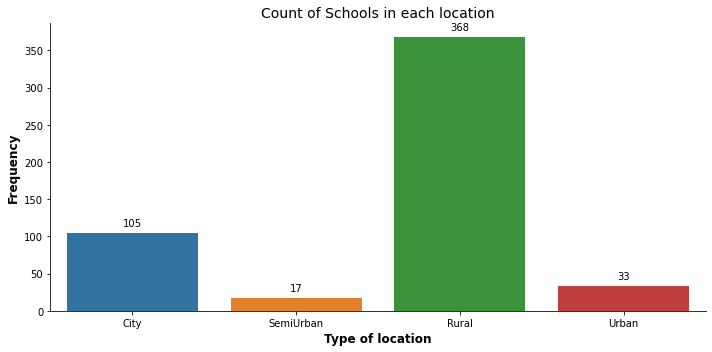

In [16]:
fig, axes = plt.subplots(figsize=(10,5))
fig.subplots_adjust(top=0.7)
splot = sns.countplot(x='Loc_type', data=dataset, ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('Count of Schools in each location', fontsize=14)
axes.set_xlabel('Type of location', fontsize=12, weight='bold')
axes.set_ylabel('Frequency', fontsize=12, weight='bold')
# axes.set_xticklabels(['<0DM', '0-200DM', '>200DM', 'No A/C'], fontsize=11)
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

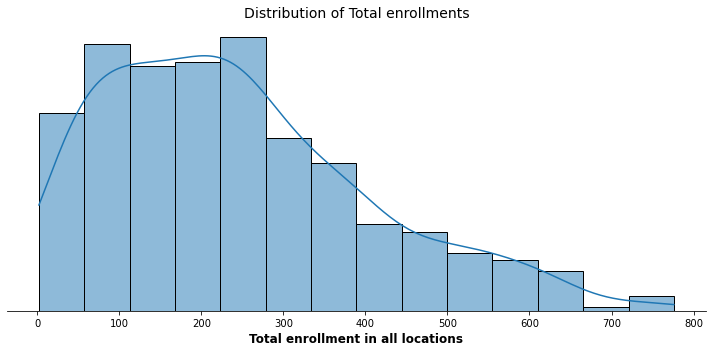

In [17]:
fig, axes = plt.subplots(figsize=(10,5))
fig.subplots_adjust(top=0.7)
sns.histplot (dataset.Tot_enrol, ax=axes, kde=True);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.axes.get_yaxis().set_visible(False)
axes.set_title('Distribution of Total enrollments', fontsize=14)
axes.set_xlabel('Total enrollment in all locations', fontsize=12, weight='bold')
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

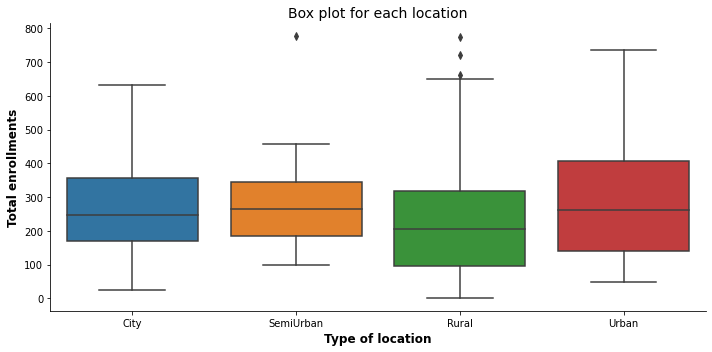

In [18]:
fig, axes = plt.subplots(figsize=(10,5))
fig.subplots_adjust(top=0.7)
splot = sns.boxplot(x='Loc_type', y='Tot_enrol', data=dataset, ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('Box plot for each location', fontsize=14)
axes.set_xlabel('Type of location', fontsize=12, weight='bold')
axes.set_ylabel('Total enrollments', fontsize=12, weight='bold')
# axes.set_xticklabels(['<0DM', '0-200DM', '>200DM', 'No A/C'], fontsize=11)
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

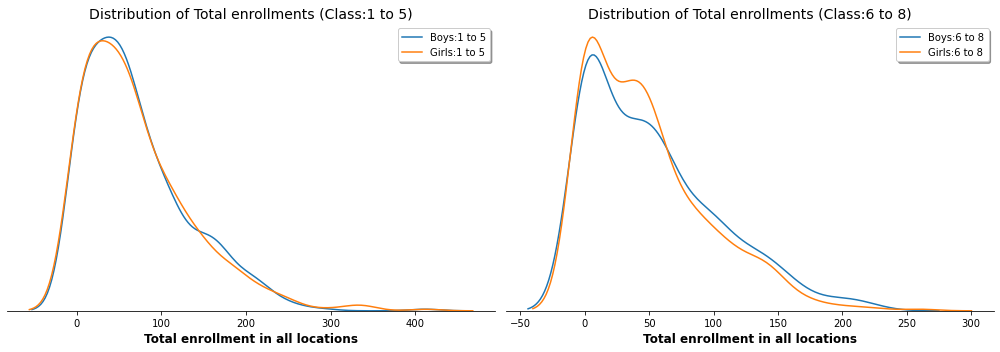

In [19]:
##Create the grid
fig, axes = plt.subplots(1, 2, figsize=(14,5))
fig.subplots_adjust(top=0.7)

sns.kdeplot(dataset.S_1_5_Boys, label="Boys:1 to 5", ax=axes[0])
sns.kdeplot(dataset.S_1_5_Girls, label="Girls:1 to 5", ax=axes[0]);
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].axes.get_yaxis().set_visible(False)
axes[0].set_title('Distribution of Total enrollments (Class:1 to 5)', fontsize=14)
axes[0].set_xlabel('Total enrollment in all locations', fontsize=12, weight='bold')
axes[0].legend(loc='best', shadow=True,fontsize='medium')

sns.kdeplot(dataset.S_6_8_Boys, label="Boys:6 to 8", ax=axes[1])
sns.kdeplot(dataset.S_6_8_Girls, label="Girls:6 to 8", ax=axes[1]);
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].axes.get_yaxis().set_visible(False)
axes[1].set_title('Distribution of Total enrollments (Class:6 to 8)', fontsize=14)
axes[1].set_xlabel('Total enrollment in all locations', fontsize=12, weight='bold')
axes[1].legend(loc='best', shadow=True,fontsize='medium')

fig.tight_layout()
plt.show()

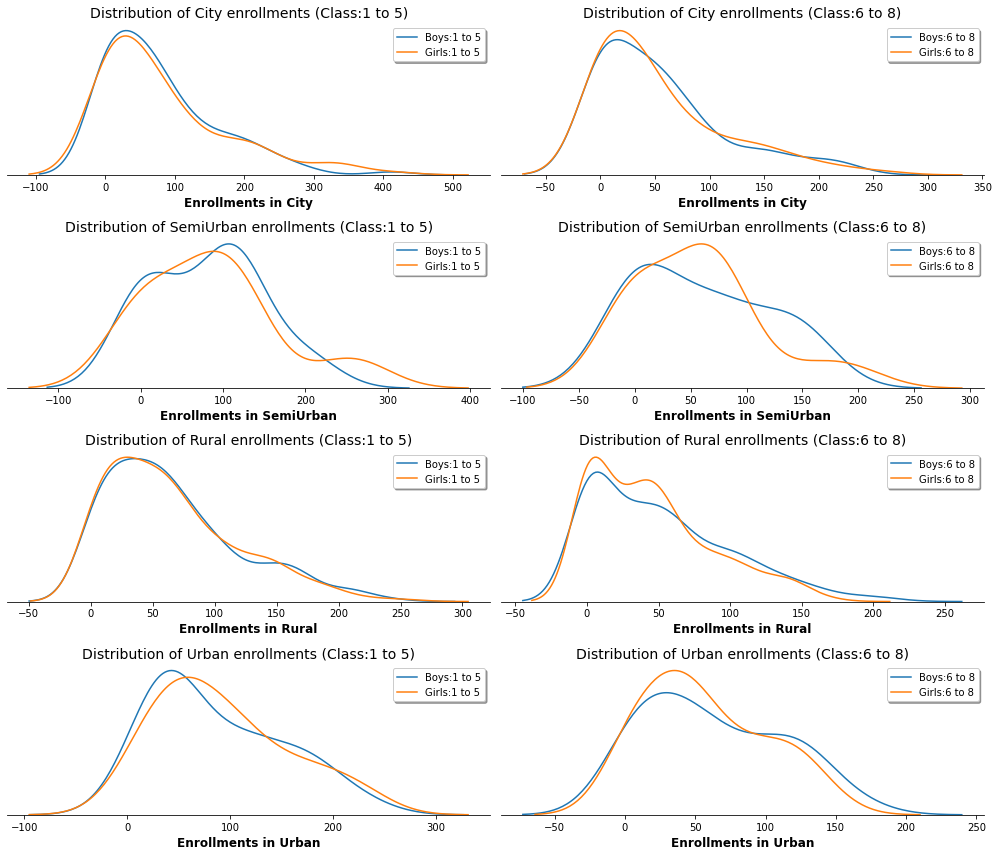

In [20]:
# dataset.loc[dataset['Loc_type']=="City", "S_1_5_Boys"]
##Create the grid
fig, axes = plt.subplots(4, 2, figsize=(14,12))
fig.subplots_adjust(top=0.7)

##1st row
x1data=dataset.loc[dataset['Loc_type']=="City", "S_1_5_Boys"]
x2data=dataset.loc[dataset['Loc_type']=="City", "S_1_5_Girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[0,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[0,0]);
axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['left'].set_visible(False)
axes[0,0].axes.get_yaxis().set_visible(False)
axes[0,0].set_title('Distribution of City enrollments (Class:1 to 5)', fontsize=14)
axes[0,0].set_xlabel('Enrollments in City', fontsize=12, weight='bold')
axes[0,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=dataset.loc[dataset['Loc_type']=="City", "S_6_8_Boys"]
x2data=dataset.loc[dataset['Loc_type']=="City", "S_6_8_Girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[0,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[0,1]);
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['left'].set_visible(False)
axes[0,1].axes.get_yaxis().set_visible(False)
axes[0,1].set_title('Distribution of City enrollments (Class:6 to 8)', fontsize=14)
axes[0,1].set_xlabel('Enrollments in City', fontsize=12, weight='bold')
axes[0,1].legend(loc='best', shadow=True,fontsize='medium')

##2nd row
x1data=dataset.loc[dataset['Loc_type']=="SemiUrban", "S_1_5_Boys"]
x2data=dataset.loc[dataset['Loc_type']=="SemiUrban", "S_1_5_Girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[1,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[1,0]);
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['left'].set_visible(False)
axes[1,0].axes.get_yaxis().set_visible(False)
axes[1,0].set_title('Distribution of SemiUrban enrollments (Class:1 to 5)', fontsize=14)
axes[1,0].set_xlabel('Enrollments in SemiUrban', fontsize=12, weight='bold')
axes[1,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=dataset.loc[dataset['Loc_type']=="SemiUrban", "S_6_8_Boys"]
x2data=dataset.loc[dataset['Loc_type']=="SemiUrban", "S_6_8_Girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[1,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[1,1]);
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['left'].set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
axes[1,1].set_title('Distribution of SemiUrban enrollments (Class:6 to 8)', fontsize=14)
axes[1,1].set_xlabel('Enrollments in SemiUrban', fontsize=12, weight='bold')
axes[1,1].legend(loc='best', shadow=True,fontsize='medium')

##3rd row
x1data=dataset.loc[dataset['Loc_type']=="Rural", "S_1_5_Boys"]
x2data=dataset.loc[dataset['Loc_type']=="Rural", "S_1_5_Girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[2,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[2,0]);
axes[2,0].spines['top'].set_visible(False)
axes[2,0].spines['right'].set_visible(False)
axes[2,0].spines['left'].set_visible(False)
axes[2,0].axes.get_yaxis().set_visible(False)
axes[2,0].set_title('Distribution of Rural enrollments (Class:1 to 5)', fontsize=14)
axes[2,0].set_xlabel('Enrollments in Rural', fontsize=12, weight='bold')
axes[2,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=dataset.loc[dataset['Loc_type']=="Rural", "S_6_8_Boys"]
x2data=dataset.loc[dataset['Loc_type']=="Rural", "S_6_8_Girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[2,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[2,1]);
axes[2,1].spines['top'].set_visible(False)
axes[2,1].spines['right'].set_visible(False)
axes[2,1].spines['left'].set_visible(False)
axes[2,1].axes.get_yaxis().set_visible(False)
axes[2,1].set_title('Distribution of Rural enrollments (Class:6 to 8)', fontsize=14)
axes[2,1].set_xlabel('Enrollments in Rural', fontsize=12, weight='bold')
axes[2,1].legend(loc='best', shadow=True,fontsize='medium')

##4th row
x1data=dataset.loc[dataset['Loc_type']=="Urban", "S_1_5_Boys"]
x2data=dataset.loc[dataset['Loc_type']=="Urban", "S_1_5_Girls"]
sns.kdeplot(x1data, label="Boys:1 to 5", ax=axes[3,0])
sns.kdeplot(x2data, label="Girls:1 to 5", ax=axes[3,0]);
axes[3,0].spines['top'].set_visible(False)
axes[3,0].spines['right'].set_visible(False)
axes[3,0].spines['left'].set_visible(False)
axes[3,0].axes.get_yaxis().set_visible(False)
axes[3,0].set_title('Distribution of Urban enrollments (Class:1 to 5)', fontsize=14)
axes[3,0].set_xlabel('Enrollments in Urban', fontsize=12, weight='bold')
axes[3,0].legend(loc='best', shadow=True,fontsize='medium')

x1data=dataset.loc[dataset['Loc_type']=="Urban", "S_6_8_Boys"]
x2data=dataset.loc[dataset['Loc_type']=="Urban", "S_6_8_Girls"]
sns.kdeplot(x1data, label="Boys:6 to 8", ax=axes[3,1])
sns.kdeplot(x2data, label="Girls:6 to 8", ax=axes[3,1]);
axes[3,1].spines['top'].set_visible(False)
axes[3,1].spines['right'].set_visible(False)
axes[3,1].spines['left'].set_visible(False)
axes[3,1].axes.get_yaxis().set_visible(False)
axes[3,1].set_title('Distribution of Urban enrollments (Class:6 to 8)', fontsize=14)
axes[3,1].set_xlabel('Enrollments in Urban', fontsize=12, weight='bold')
axes[3,1].legend(loc='best', shadow=True,fontsize='medium')

fig.tight_layout()
plt.show()

In [21]:
del x1data, x2data

**Data preparation for clustering**

In [22]:
X = dataset[["S_1_5_Boys", "S_1_5_Girls", "S_6_8_Boys", "S_6_8_Girls", "Loc_type"]]

In [23]:
eqfdisctr1 = EqualFrequencyDiscretiser(q=20, variables = ['S_1_5_Boys', 'S_1_5_Girls', 'S_6_8_Boys', 'S_6_8_Girls'],
                                     return_object=True)

In [24]:
eqfdisctr1.fit(X)
X1 = eqfdisctr1.transform(X)

In [25]:
for i in range(len(X1.columns)):
    if X1[X1.columns[i]].dtype != 'object':
        X1[X1.columns[i]] = X1[X1.columns[i]].apply(lambda x: str(x))

In [26]:
col_list = list(X1.columns)

In [27]:
rare_label_encoder = RareLabelCategoricalEncoder(
    tol=0.01,
    n_categories=2,
    variables=col_list
)

In [28]:
rare_label_encoder.fit(X1)

RareLabelCategoricalEncoder(n_categories=2, tol=0.01,
                            variables=['S_1_5_Boys', 'S_1_5_Girls',
                                       'S_6_8_Boys', 'S_6_8_Girls',
                                       'Loc_type'])

In [29]:
X2 = rare_label_encoder.transform(X1)

In [30]:
ordered_label_encoder = OrdinalCategoricalEncoder(
    encoding_method='arbitrary',
    variables=col_list)

In [31]:
ordered_label_encoder.fit(X2)

OrdinalCategoricalEncoder(encoding_method='arbitrary',
                          variables=['S_1_5_Boys', 'S_1_5_Girls', 'S_6_8_Boys',
                                     'S_6_8_Girls', 'Loc_type'])

In [32]:
# ordered_label_encoder.encoder_dict_
# ordered_label_encoder.variables
X3 = ordered_label_encoder.transform(X2)

**Gower distance**

In [33]:
store = []
for i in range(len(X3.columns)):
    a = True
    store.append(a)

In [34]:
len(store)

5

In [35]:
for i in range(len(X3.columns)):
    if X3[X3.columns[i]].dtype != 'float':
        X3[X3.columns[i]] = X3[X3.columns[i]].apply(lambda x: float(x))

In [36]:
distance_matrix = gower.gower_matrix(X3, cat_features = store)

**Hierarchical Clustering**

<ipython-input-37-d8bf45507cd8>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Zd = sch.linkage(distance_matrix, method='complete', metric='hamming')


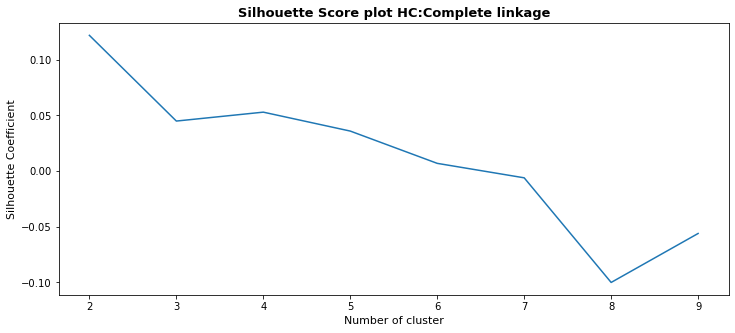

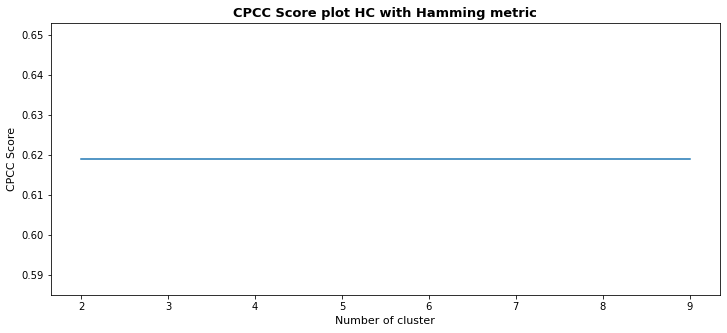

In [37]:
sil_score = {}
cpcc = {}
Zd = sch.linkage(distance_matrix, method='complete', metric='hamming')

for k in range(2, 10):
    ##https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
    hc = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete').fit(distance_matrix)
    label = hc.labels_
    sil_score[k] = round(silhouette_score(distance_matrix, label, metric="precomputed"),3)
    ##https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    c, coph_dists = sch.cophenet(Zd, pdist(X3, metric="hamming"))
    cpcc[k] = round(c,3)

plt.figure(figsize=(12,5))
plt.plot(list(sil_score.keys()), list(sil_score.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Silhouette Coefficient", fontsize=11)
plt.title("Silhouette Score plot HC:Complete linkage", fontsize=13, weight='bold')

plt.figure(figsize=(12,5))
plt.plot(list(cpcc.keys()), list(cpcc.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("CPCC Score", fontsize=11)
plt.title("CPCC Score plot HC with Hamming metric", fontsize=13, weight='bold')

plt.show()

<ipython-input-38-99de76cca1cd>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Zd = sch.linkage(distance_matrix, method='average', metric='hamming')


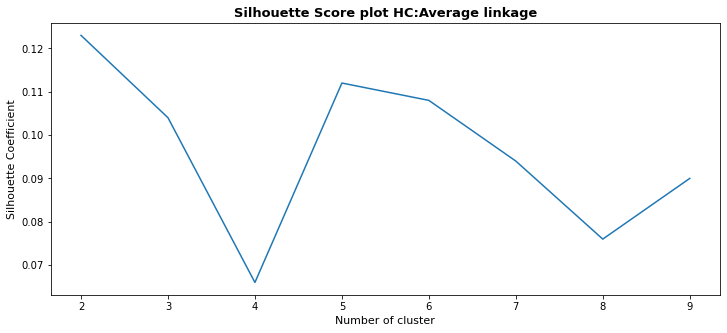

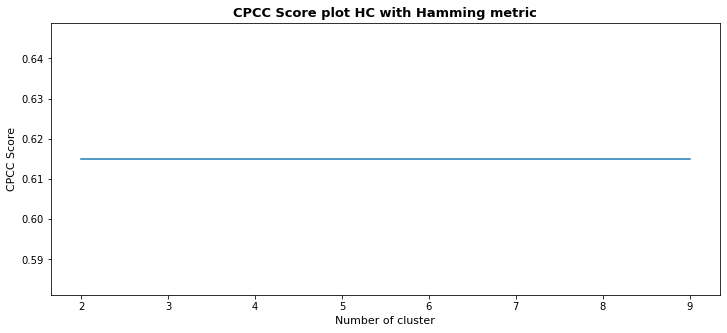

In [38]:
sil_score = {}
cpcc = {}
Zd = sch.linkage(distance_matrix, method='average', metric='hamming')

for k in range(2, 10):
    ##https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
    hc = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='average').fit(distance_matrix)
    label = hc.labels_
    sil_score[k] = round(silhouette_score(distance_matrix, label, metric="precomputed"),3)
    ##https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    c, coph_dists = sch.cophenet(Zd, pdist(X3, metric="hamming"))
    cpcc[k] = round(c,3)

plt.figure(figsize=(12,5))
plt.plot(list(sil_score.keys()), list(sil_score.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Silhouette Coefficient", fontsize=11)
plt.title("Silhouette Score plot HC:Average linkage", fontsize=13, weight='bold')

plt.figure(figsize=(12,5))
plt.plot(list(cpcc.keys()), list(cpcc.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("CPCC Score", fontsize=11)
plt.title("CPCC Score plot HC with Hamming metric", fontsize=13, weight='bold')

plt.show()

<ipython-input-39-0f8675e33595>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Zd = sch.linkage(distance_matrix, method='single', metric='hamming')


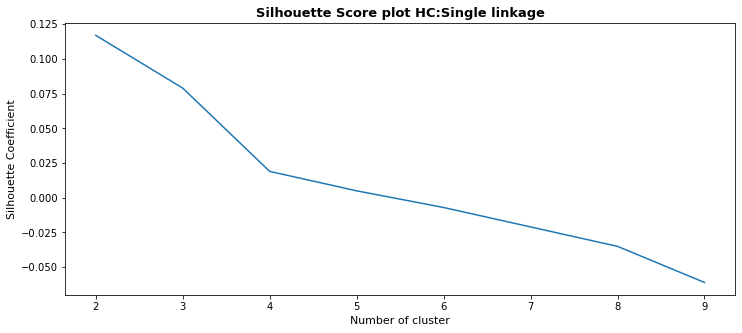

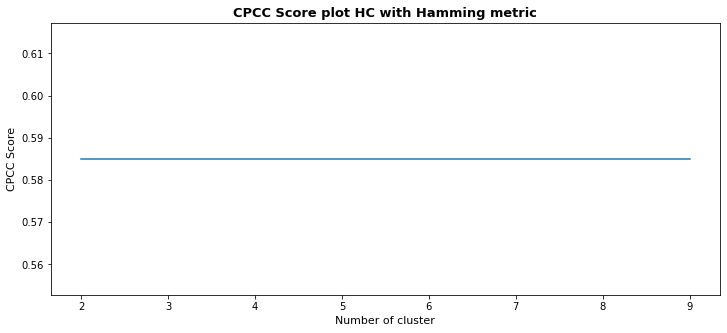

In [39]:
sil_score = {}
cpcc = {}
Zd = sch.linkage(distance_matrix, method='single', metric='hamming')

for k in range(2, 10):
    ##https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
    hc = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single').fit(distance_matrix)
    label = hc.labels_
    sil_score[k] = round(silhouette_score(distance_matrix, label, metric="precomputed"),3)
    ##https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    c, coph_dists = sch.cophenet(Zd, pdist(X3, metric="hamming"))
    cpcc[k] = round(c,3)

plt.figure(figsize=(12,5))
plt.plot(list(sil_score.keys()), list(sil_score.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Silhouette Coefficient", fontsize=11)
plt.title("Silhouette Score plot HC:Single linkage", fontsize=13, weight='bold')

plt.figure(figsize=(12,5))
plt.plot(list(cpcc.keys()), list(cpcc.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("CPCC Score", fontsize=11)
plt.title("CPCC Score plot HC with Hamming metric", fontsize=13, weight='bold')

plt.show()

<ipython-input-40-022bd80674a4>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Zd = sch.linkage(distance_matrix, method='centroid', metric='euclidean')


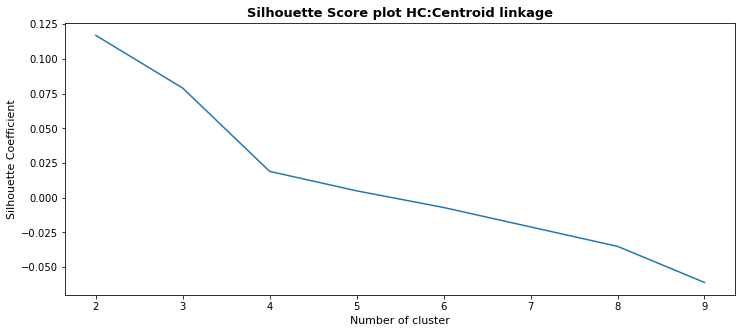

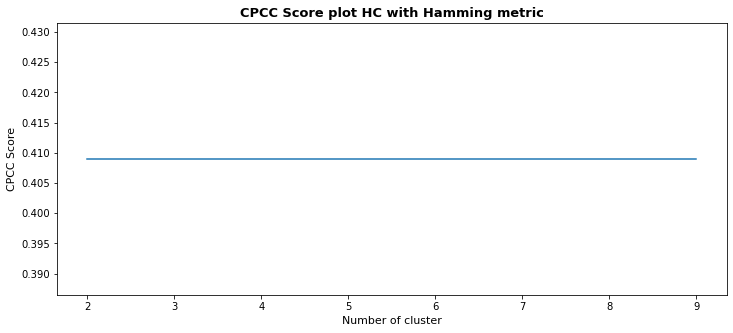

In [40]:
sil_score = {}
cpcc = {}
Zd = sch.linkage(distance_matrix, method='centroid', metric='euclidean')

for k in range(2, 10):
    ##https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
    hc = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single').fit(distance_matrix)
    label = hc.labels_
    sil_score[k] = round(silhouette_score(distance_matrix, label, metric="precomputed"),3)
    ##https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    c, coph_dists = sch.cophenet(Zd, pdist(X3, metric="hamming"))
    cpcc[k] = round(c,3)

plt.figure(figsize=(12,5))
plt.plot(list(sil_score.keys()), list(sil_score.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Silhouette Coefficient", fontsize=11)
plt.title("Silhouette Score plot HC:Centroid linkage", fontsize=13, weight='bold')

plt.figure(figsize=(12,5))
plt.plot(list(cpcc.keys()), list(cpcc.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("CPCC Score", fontsize=11)
plt.title("CPCC Score plot HC with Hamming metric", fontsize=13, weight='bold')

plt.show()

<ipython-input-41-88a8e31700fc>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Zd = sch.linkage(distance_matrix, method='ward', metric='euclidean')


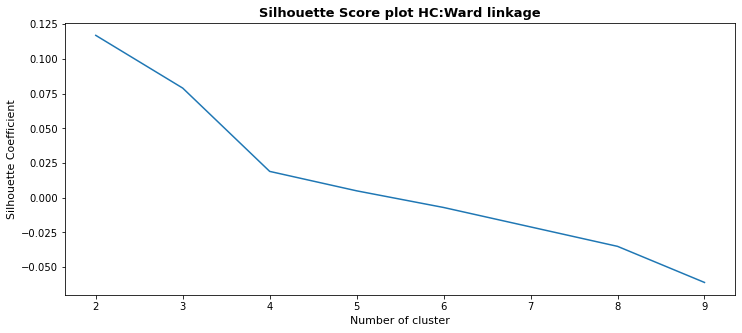

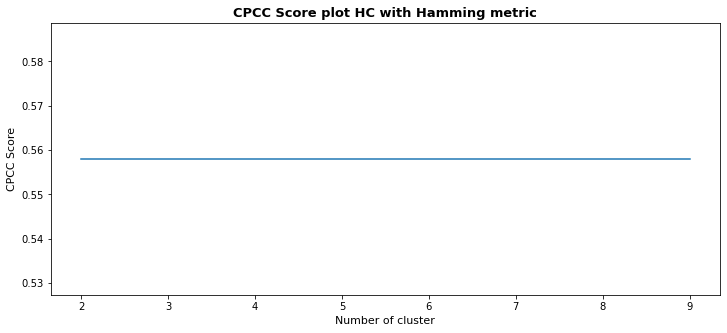

In [41]:
sil_score = {}
cpcc = {}
Zd = sch.linkage(distance_matrix, method='ward', metric='euclidean')

for k in range(2, 10):
    ##https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
    hc = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single').fit(distance_matrix)
    label = hc.labels_
    sil_score[k] = round(silhouette_score(distance_matrix, label, metric="precomputed"),3)
    ##https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    c, coph_dists = sch.cophenet(Zd, pdist(X3, metric="hamming"))
    cpcc[k] = round(c,3)

plt.figure(figsize=(12,5))
plt.plot(list(sil_score.keys()), list(sil_score.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Silhouette Coefficient", fontsize=11)
plt.title("Silhouette Score plot HC:Ward linkage", fontsize=13, weight='bold')

plt.figure(figsize=(12,5))
plt.plot(list(cpcc.keys()), list(cpcc.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("CPCC Score", fontsize=11)
plt.title("CPCC Score plot HC with Hamming metric", fontsize=13, weight='bold')

plt.show()

**K-Modes**

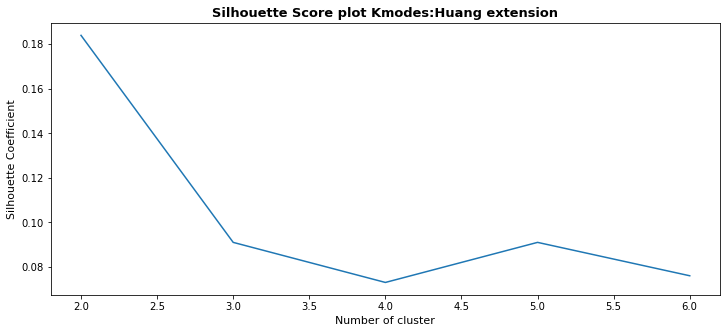

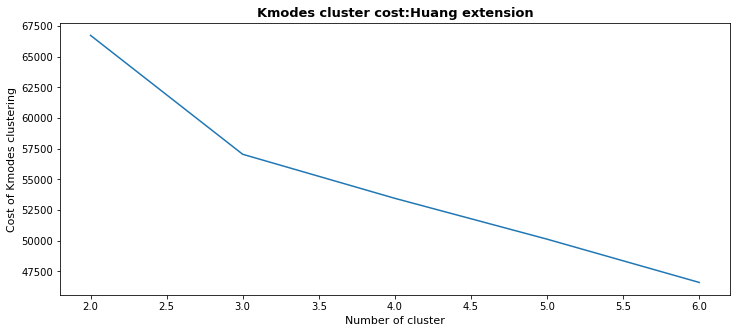

In [42]:
sil_score = {}
kmcost = {}

for k in range(2, 7):
    ##https://pypi.org/project/kmodes/
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0).fit(distance_matrix)
    label = km.labels_
    sil_score[k] = round(silhouette_score(distance_matrix, label, metric="precomputed"),3)
    kmcost[k] = km.cost_

plt.figure(figsize=(12,5))
plt.plot(list(sil_score.keys()), list(sil_score.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Silhouette Coefficient", fontsize=11)
plt.title("Silhouette Score plot Kmodes:Huang extension", fontsize=13, weight='bold')

plt.figure(figsize=(12,5))
plt.plot(list(kmcost.keys()), list(kmcost.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Cost of Kmodes clustering", fontsize=11)
plt.title("Kmodes cluster cost:Huang extension", fontsize=13, weight='bold')

plt.show()

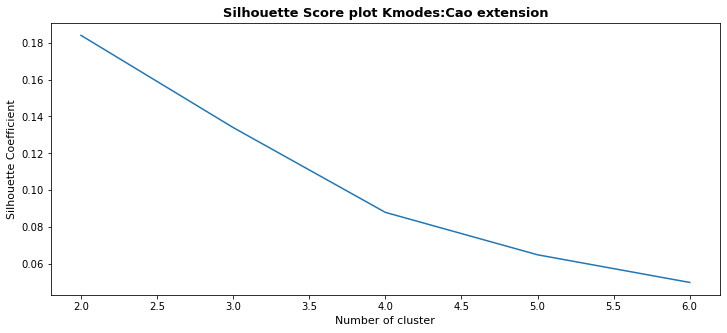

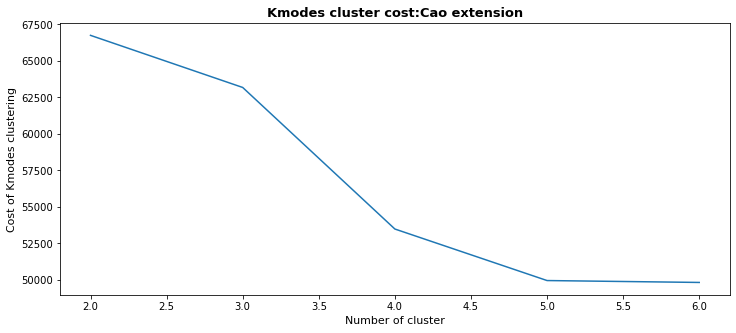

In [43]:
sil_score = {}
kmcost = {}

for k in range(2, 7):
    ##https://pypi.org/project/kmodes/
    km = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0).fit(distance_matrix)
    label = km.labels_
    sil_score[k] = round(silhouette_score(distance_matrix, label, metric="precomputed"),3)
    kmcost[k] = km.cost_

plt.figure(figsize=(12,5))
plt.plot(list(sil_score.keys()), list(sil_score.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Silhouette Coefficient", fontsize=11)
plt.title("Silhouette Score plot Kmodes:Cao extension", fontsize=13, weight='bold')

plt.figure(figsize=(12,5))
plt.plot(list(kmcost.keys()), list(kmcost.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Cost of Kmodes clustering", fontsize=11)
plt.title("Kmodes cluster cost:Cao extension", fontsize=13, weight='bold')

plt.show()

**Kmediods Clustering**

**Due to kmeanss++ initializer the optimal cluster count may change on next run**

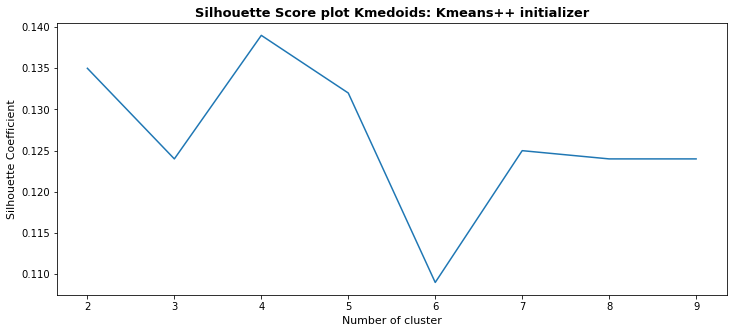

In [44]:
distance_matrix1 = distance_matrix + np.transpose(distance_matrix)
sil_score = {}

for k in range(2, 10):
    # Prepare initial centers
    medoids = kmeans_plusplus_initializer(distance_matrix1, k).initialize(return_index=True)
    # Perform cluster analysis
    kmedoids_instance = kmedoids(distance_matrix1, medoids, data_type='distance_matrix')
    clusters = kmedoids_instance.process().get_clusters()
    med = kmedoids_instance.get_medoids()
    score = silhouette(distance_matrix1, clusters).process().get_score()
    
    # by default kmedoids returns representation CLUSTER_INDEX_LIST_SEPARATION
    type_repr = kmedoids_instance.get_cluster_encoding();
    encoder = cluster_encoder(type_repr, clusters, distance_matrix1);
    encoder.set_encoding(type_encoding.CLUSTER_INDEX_LABELING);
    # print("Index Labeling:", encoder.get_clusters())
    labels = encoder.get_clusters()
    sil_score[k] = round(silhouette_score(distance_matrix1, labels, metric="precomputed"),3)

plt.figure(figsize=(12,5))
plt.plot(list(sil_score.keys()), list(sil_score.values()))
plt.xlabel("Number of cluster", fontsize=11)
plt.ylabel("Silhouette Coefficient", fontsize=11)
plt.title("Silhouette Score plot Kmedoids: Kmeans++ initializer", fontsize=13, weight='bold')


plt.show()

**Run final chosen methods separately to collect cluster ids**

In [45]:
Zd = sch.linkage(distance_matrix, method='average', metric='hamming')
hc = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='average').fit(distance_matrix)
label_hc = hc.labels_

<ipython-input-45-7c5350862774>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Zd = sch.linkage(distance_matrix, method='average', metric='hamming')


In [46]:
km = KModes(n_clusters=2, init='Huang', n_init=2, verbose=0).fit(distance_matrix)
label_km = km.labels_

In [47]:
# Prepare initial centers
medoids = kmeans_plusplus_initializer(distance_matrix1, 4).initialize(return_index=True)
# Perform cluster analysis
kmedoids_instance = kmedoids(distance_matrix1, medoids, data_type='distance_matrix')
clusters = kmedoids_instance.process().get_clusters()
med = kmedoids_instance.get_medoids()
score = silhouette(distance_matrix1, clusters).process().get_score()
 
# by default kmedoids returns representation CLUSTER_INDEX_LIST_SEPARATION
type_repr = kmedoids_instance.get_cluster_encoding();
encoder = cluster_encoder(type_repr, clusters, distance_matrix1);
encoder.set_encoding(type_encoding.CLUSTER_INDEX_LABELING);
# print("Index Labeling:", encoder.get_clusters())
label_kmediods = encoder.get_clusters()

In [48]:
a = pd.DataFrame(list(label_hc), columns=['id_hc'])
b = pd.DataFrame(list(label_km), columns=['id_kmodes'])
c = pd.DataFrame(list(label_kmediods), columns=['id_kmediods'])

In [49]:
results = pd.concat([a, b, c], axis=1)

In [50]:
results.id_hc.value_counts().sort_index()

0     56
1    467
Name: id_hc, dtype: int64

In [51]:
results.id_kmodes.value_counts().sort_index()

0    155
1    368
Name: id_kmodes, dtype: int64

In [52]:
results.id_kmediods.value_counts().sort_index()

0    190
1    193
2     79
3     61
Name: id_kmediods, dtype: int64

In [53]:
explore_data = pd.merge(results, dataset, left_index=True, right_index=True)

In [54]:
explore_data.head()

,id_hc,id_kmodes,id_kmediods,Center_No,Sl.No.,Tot_enrol,S_1_5_Boys,S_1_5_Girls,S_6_8_Boys,S_6_8_Girls,Loc_type
0,1,0,1,GXZ-CU1,1,42,14,16,4,8,City
1,1,0,3,GXZ-CU2,2,206,48,33,81,44,City
2,0,0,3,GXZ-CU3,3,93,25,26,14,28,City
3,0,0,3,GXZ-CU4,4,126,36,42,27,21,City
4,1,0,3,GXZ-CU5,5,65,27,17,13,8,City


**Find top attributes to characterise**

In [55]:
sc = StandardScaler()
X3_sc = pd.DataFrame(sc.fit_transform(X3))
X3_sc.columns = X3.columns
X3_sc['id_kmediods'] = label_kmediods

In [56]:
df_mean = (X3_sc.loc[: , :].groupby('id_kmediods').mean())
results = pd.DataFrame(columns=['Variable', 'Var'])
for column in df_mean.columns[0:]:
    results.loc[len(results), :] = [column, np.var(df_mean[column])]

selected_columns = list(results.sort_values('Var', ascending=False).Variable.values) + ['id_kmediods']

In [57]:
selected_columns

['S_6_8_Girls',
 'S_1_5_Girls',
 'S_6_8_Boys',
 'S_1_5_Boys',
 'Loc_type',
 'id_kmediods']

In [58]:
#explore_data.to_csv("explore_data.csv")

**Imort food distribution data and join cluster ids**

In [59]:
#Import data
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/articles/food_distribution_schools.csv"
food_dist_data = pd.read_csv(url, error_bad_lines=False, header=0, index_col=None, parse_dates=True, date_parser=['Ben_Date'],
                            encoding = "ISO-8859-1")

In [60]:
food_dist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6396 entries, 0 to 6395
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ben_Date              6396 non-null   object 
 1   School_Id_Masked      6396 non-null   object 
 2   Route_Index           6360 non-null   float64
 3   V_rice_big            2999 non-null   float64
 4   V_rice_med            3294 non-null   float64
 5   V_rice_sma            1609 non-null   float64
 6   W_rice_big            1799 non-null   float64
 7   W_rice_med            2043 non-null   float64
 8   W_rice_sma            1214 non-null   float64
 9   censored              6396 non-null   int64  
 10  Total_Inventory_KG    6396 non-null   float64
 11  Total_Returns_KG      6396 non-null   float64
 12  Total_Consumption_KG  6396 non-null   float64
 13  Mixed_Demand          6396 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 699.7+ KB


In [61]:
food_dist_data = food_dist_data.loc[food_dist_data['School_Id_Masked']!="XZNOWAXZSYZXYTAXZGXZE", ]

food_enroll = pd.merge(food_dist_data, explore_data, left_on='School_Id_Masked', right_on='Center_No')

food_enroll.shape

(6210, 25)

In [62]:
food_enroll['Ben_Date'] = pd.DatetimeIndex(food_enroll['Ben_Date'])

food_enroll = food_enroll.sort_values(by=['School_Id_Masked', 'Ben_Date'], ascending=[False, True])

In [63]:
review_dataset = food_enroll[['School_Id_Masked', 'Ben_Date', 'censored', 'Mixed_Demand',
                             'id_kmediods', 'id_kmodes', 'id_hc',
                             'Tot_enrol', 'S_1_5_Boys', 'S_1_5_Girls', 'S_6_8_Boys', 'S_6_8_Girls', 'Loc_type',
                             'V_rice_big', 'V_rice_med', 'V_rice_sma',
                             'W_rice_big', 'W_rice_med', 'W_rice_sma',
                             'Total_Inventory_KG','Total_Returns_KG', 'Total_Consumption_KG']]

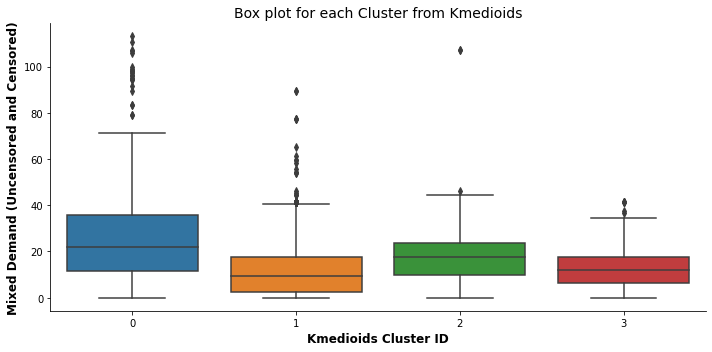

In [64]:
fig, axes = plt.subplots(figsize=(10,5))
fig.subplots_adjust(top=0.7)
splot = sns.boxplot(x='id_kmediods', y='Mixed_Demand', data=review_dataset, ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('Box plot for each Cluster from Kmedioids', fontsize=14)
axes.set_xlabel('Kmedioids Cluster ID', fontsize=12, weight='bold')
axes.set_ylabel('Mixed Demand (Uncensored and Censored)', fontsize=12, weight='bold')
# axes.set_xticklabels(['<0DM', '0-200DM', '>200DM', 'No A/C'], fontsize=11)
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

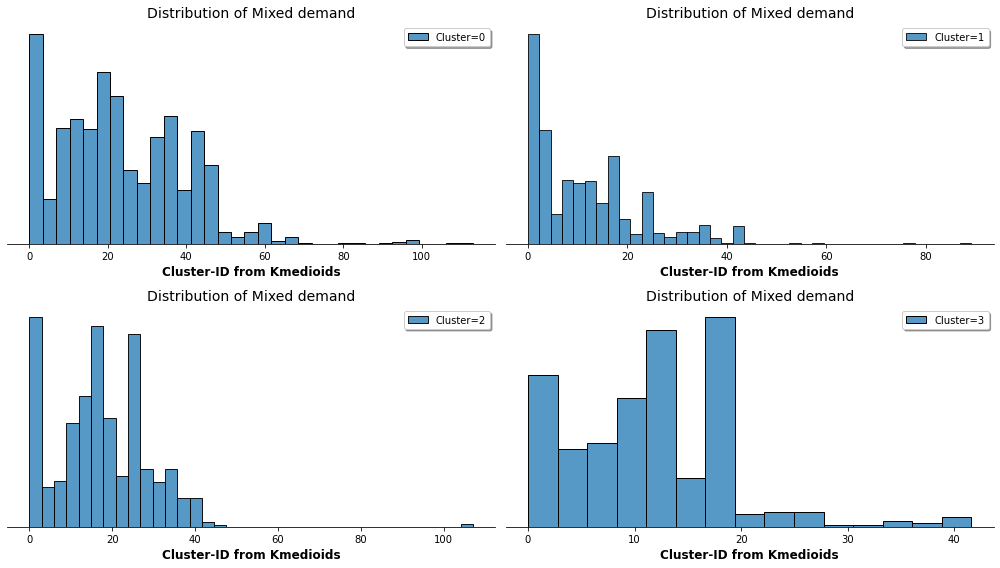

In [65]:
# dataset.loc[dataset['Loc_type']=="City", "S_1_5_Boys"]
##Create the grid
fig, axes = plt.subplots(2, 2, figsize=(14,8))
fig.subplots_adjust(top=0.7)

##1st row
x1data=review_dataset.loc[review_dataset['id_kmediods']==0, "Mixed_Demand"]
sns.histplot(x1data, label="Cluster=0", ax=axes[0,0]);
axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['left'].set_visible(False)
axes[0,0].axes.get_yaxis().set_visible(False)
axes[0,0].set_title('Distribution of Mixed demand', fontsize=14)
axes[0,0].set_xlabel('Cluster-ID from Kmedioids', fontsize=12, weight='bold')
axes[0,0].legend(loc='best', shadow=True,fontsize='medium')

##2nd row
x1data=review_dataset.loc[review_dataset['id_kmediods']==1, "Mixed_Demand"]
sns.histplot(x1data, label="Cluster=1", ax=axes[0,1]);
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['left'].set_visible(False)
axes[0,1].axes.get_yaxis().set_visible(False)
axes[0,1].set_title('Distribution of Mixed demand', fontsize=14)
axes[0,1].set_xlabel('Cluster-ID from Kmedioids', fontsize=12, weight='bold')
axes[0,1].legend(loc='best', shadow=True,fontsize='medium')

##3rd row
x1data=review_dataset.loc[review_dataset['id_kmediods']==2, "Mixed_Demand"]
sns.histplot(x1data, label="Cluster=2", ax=axes[1,0]);
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['left'].set_visible(False)
axes[1,0].axes.get_yaxis().set_visible(False)
axes[1,0].set_title('Distribution of Mixed demand', fontsize=14)
axes[1,0].set_xlabel('Cluster-ID from Kmedioids', fontsize=12, weight='bold')
axes[1,0].legend(loc='best', shadow=True,fontsize='medium')

##4th row
x1data=review_dataset.loc[review_dataset['id_kmediods']==3, "Mixed_Demand"]
sns.histplot(x1data, label="Cluster=3", ax=axes[1,1]);
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['left'].set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
axes[1,1].set_title('Distribution of Mixed demand', fontsize=14)
axes[1,1].set_xlabel('Cluster-ID from Kmedioids', fontsize=12, weight='bold')
axes[1,1].legend(loc='best', shadow=True,fontsize='medium')

fig.tight_layout()
plt.show()

In [66]:
# review_dataset.to_csv("review_dataset.csv")

In [67]:
# !pip install --quiet lifelines
from lifelines import KaplanMeierFitter

In [68]:
review_dataset['id_kmediods'].value_counts().sort_index()

0    2556
1    2323
2     822
3     509
Name: id_kmediods, dtype: int64

In [69]:
clus0_data = review_dataset.loc[review_dataset['id_kmediods']==0, ]

clus0_data = clus0_data.drop_duplicates(keep='first', subset=["School_Id_Masked", "Ben_Date"], ignore_index=True)

In [70]:
clus0_data.shape

(2515, 22)

In [71]:
clus0_data['censored'].sum()

585

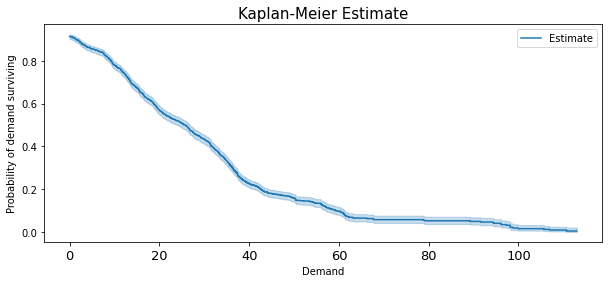

In [88]:
kmf = KaplanMeierFitter()
kmf.fit(durations=clus0_data["Mixed_Demand"], event_observed=1-clus0_data["censored"], label="Estimate", ci_labels=["Lower", "Upper"])

event_table = kmf.event_table

est = kmf.survival_function_

conf_int = kmf.confidence_interval_survival_function_

out = pd.merge(est, conf_int, left_index=True, right_index=True)

kmf.plot(figsize=(10,4));
plt.title('Kaplan-Meier Estimate', fontsize=15)
plt.ylabel("Probability of demand surviving")
plt.xlabel("Demand")
plt.xticks(fontsize=13)
plt.show()

In [90]:
# out.to_csv("out.csv")
# clus0_data.to_csv("clus0_data.csv")

In [91]:
clus1_data = review_dataset.loc[review_dataset['id_kmediods']==1, ]

clus1_data = clus1_data.drop_duplicates(keep='first', subset=["School_Id_Masked", "Ben_Date"], ignore_index=True)

In [92]:
clus1_data.shape

(2313, 22)

In [93]:
del kmf, event_table, est, conf_int, out

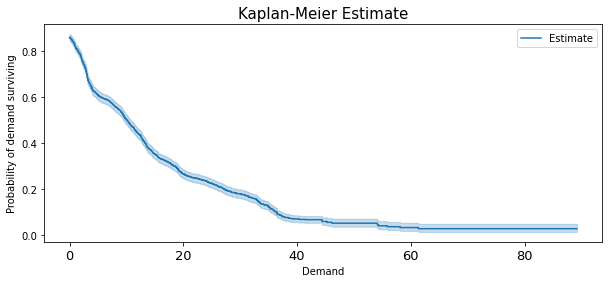

In [94]:
kmf = KaplanMeierFitter()
kmf.fit(durations=clus1_data["Mixed_Demand"], event_observed=1-clus1_data["censored"], label="Estimate", ci_labels=["Lower", "Upper"])

event_table = kmf.event_table

est = kmf.survival_function_

conf_int = kmf.confidence_interval_survival_function_

out = pd.merge(est, conf_int, left_index=True, right_index=True)

kmf.plot(figsize=(10,4));
plt.title('Kaplan-Meier Estimate', fontsize=15)
plt.ylabel("Probability of demand surviving")
plt.xlabel("Demand")
plt.xticks(fontsize=13)
plt.show()

In [95]:
# out.to_csv("out.csv")
# clus1_data.to_csv("clus1_data.csv")

In [96]:
clus2_data = review_dataset.loc[review_dataset['id_kmediods']==2, ]

clus2_data = clus2_data.drop_duplicates(keep='first', subset=["School_Id_Masked", "Ben_Date"], ignore_index=True)

In [97]:
clus2_data.shape

(804, 22)

In [98]:
del kmf, event_table, est, conf_int, out

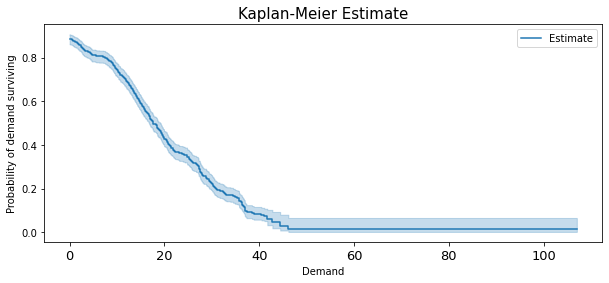

In [99]:
kmf = KaplanMeierFitter()
kmf.fit(durations=clus2_data["Mixed_Demand"], event_observed=1-clus2_data["censored"], label="Estimate", ci_labels=["Lower", "Upper"])

event_table = kmf.event_table

est = kmf.survival_function_

conf_int = kmf.confidence_interval_survival_function_

out = pd.merge(est, conf_int, left_index=True, right_index=True)

kmf.plot(figsize=(10,4));
plt.title('Kaplan-Meier Estimate', fontsize=15)
plt.ylabel("Probability of demand surviving")
plt.xlabel("Demand")
plt.xticks(fontsize=13)
plt.show()

In [100]:
# out.to_csv("out.csv")
# clus2_data.to_csv("clus2_data.csv")

In [101]:
clus3_data = review_dataset.loc[review_dataset['id_kmediods']==3, ]

clus3_data = clus3_data.drop_duplicates(keep='first', subset=["School_Id_Masked", "Ben_Date"], ignore_index=True)

In [102]:
clus3_data.shape

(506, 22)

In [103]:
del kmf, event_table, est, conf_int, out

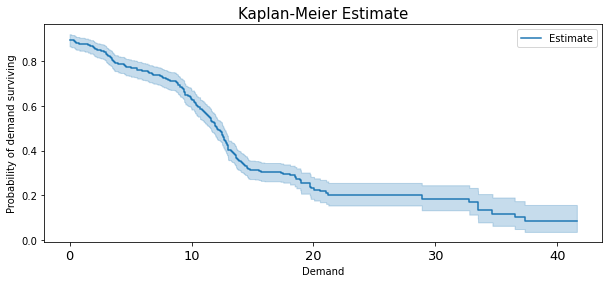

In [104]:
kmf = KaplanMeierFitter()
kmf.fit(durations=clus3_data["Mixed_Demand"], event_observed=1-clus3_data["censored"], label="Estimate", ci_labels=["Lower", "Upper"])

event_table = kmf.event_table

est = kmf.survival_function_

conf_int = kmf.confidence_interval_survival_function_

out = pd.merge(est, conf_int, left_index=True, right_index=True)

kmf.plot(figsize=(10,4));
plt.title('Kaplan-Meier Estimate', fontsize=15)
plt.ylabel("Probability of demand surviving")
plt.xlabel("Demand")
plt.xticks(fontsize=13)
plt.show()

In [105]:
# out.to_csv("out.csv")
# clus3_data.to_csv("clus3_data.csv")

In [5]:
df_temp = pd.read_excel("cluster_driven_km_inputs.xlsx")
df_temp.head()

,School_Id_Masked,Ben_Date,censored,Mixed_Demand,cluster_id,Tot_enrol,S_1_5_Boys,S_1_5_Girls,S_6_8_Boys,S_6_8_Girls,Loc_type
0,ZYD-CU8,2014-12-29,1,41.60,0,515,174,120,129,92,Urban
1,ZYD-CU8,2015-03-07,0,19.12,0,515,174,120,129,92,Urban
2,ZYD-CU8,2015-06-08,0,7.91,0,515,174,120,129,92,Urban
3,ZYD-CU8,2015-06-11,1,17.80,0,515,174,120,129,92,Urban
4,ZYD-CU8,2015-06-15,0,2.58,0,515,174,120,129,92,Urban


In [13]:
df_temp[["S_6_8_Girls", "cluster_id"]].groupby('cluster_id').describe()

S_6_8_Girls                                                      
                 count       mean        std   min   25%   50%    75%    max
cluster_id                                                                  
0               2515.0  81.330020  37.878360  11.0  48.0  84.0  107.0  159.0
1               2313.0  34.085603  59.711848   0.0   0.0   0.0   58.0  260.0
2                804.0  48.759950   8.873026  19.0  41.0  51.0   54.0   75.0
3                506.0  16.563241   8.297975   4.0  10.0  15.0   21.0   44.0

In [14]:
df_temp[["S_1_5_Girls", "cluster_id"]].groupby('cluster_id').describe()

S_1_5_Girls                                                        
                 count        mean        std   min   25%    50%    75%    max
cluster_id                                                                    
0               2515.0  117.032604  55.147020   0.0  77.0  114.0  155.0  249.0
1               2313.0   53.984436  82.750018   0.0   0.0   11.0   55.0  412.0
2                804.0   72.563433  17.588692  42.0  60.0   69.0   80.0  116.0
3                506.0   29.185771   9.718670   9.0  21.0   29.0   35.0   71.0

In [15]:
df_temp[["S_6_8_Boys", "cluster_id"]].groupby('cluster_id').describe()

S_6_8_Boys                                                       
                count       mean        std   min    25%   50%    75%    max
cluster_id                                                                  
0              2515.0  92.577336  44.748487  15.0  60.00  95.0  121.0  217.0
1              2313.0  39.574578  66.005588   0.0   0.00   0.0   91.0  231.0
2               804.0  55.794776  11.956914  16.0  50.00  54.0   62.0  101.0
3               506.0  20.017787  13.404214   6.0  10.25  13.0   27.0   81.0

In [17]:
df_temp[["S_1_5_Boys", "cluster_id"]].groupby('cluster_id').describe()

S_1_5_Boys                                                        
                count        mean        std   min   25%    50%    75%    max
cluster_id                                                                   
0              2515.0  120.824254  57.037575  17.0  76.0  119.0  160.0  234.0
1              2313.0   54.899265  80.790513   0.0   0.0   11.0   72.0  411.0
2               804.0   69.597015  14.549329  40.0  58.0   67.0   78.0  106.0
3               506.0   30.231225  11.018791  14.0  24.0   30.0   38.0   56.0

In [16]:
df_temp[["Loc_type", "cluster_id"]].groupby('cluster_id').describe()

Loc_type                    
              count unique    top  freq
cluster_id                             
0              2515      4  Rural  1754
1              2313      4  Rural  1442
2               804      4  Rural   516
3               506      3  Rural   328